In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)
set.seed(100)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

# Think of a title!!!
**DSCI 100 Project Final Report  
Group 4: Naijide Anwaer, Maggie Ruan, Yun Xing    
Date: December 05, 2021**

## Introduction 

The project provides an overview of the rock petrophysical data process by introducing the rock properties database, illustrating the exploratory data analysis, explaining the methodology, and discussing the expected outcome.

The group intends to study the relationship between the rock petrophysical measurements and the three fundamental rock types, and to answer a classification problem: given the physical properties data (eg. Density, Porosity, Resistivity, etc.) of the rock, whether it will be igneous, sedimentary, or metamorphic.

The Canadian Rock Physical Property Database (CRPPD) includes rock petrophysical measurements on over 20,000 observations collected during the last 40 years. The rock measurements available in this database are density, porosity, resistivity etc. Geographically, observations are categorized into different sample types including outcrop, subcrop, hand sample, and borehole sample. Geologically, observations are categorized into different rock types including igneous, sedimentary, and metamorphic, the three fundamental rock types.

Our classifier model will be useful in the situation where the physical property data are available while the rock type is unclassified. An example of this will be in diamond drillholes (sample type: Borehole), where not all the rock core in the borehole are brought up to the surface for visual examination. As a result, the group decided to perform the data analysis with the focus on data categorized under the sample type borehole.


## Methods

### Data importing
The preliminary data are obtained as a zip file from the Government of Canada, Natural Resources Canada website. Upon unzipping the file and bringing the original excel file into Jupiter notebook for R processing, the group noticed that R encountered a runtime error.

Indicated by read_* documentation, the column type will be imputed from the first 1000 rows on the input file. As the top 1000 data in this excel mostly contains NULL values, R automatically assigned “col_logical” as the column type for most of the columns. However, this column type conflicts with the majority of the other observations, which contain numerical values.

To solve this issue, the group decides to sort the observations in excel before importing them into Jupiter. We relocated the columns with no missing data to the top of the file, save it as a CSV file and upload it to GitHub. R successfully created columns with the proper type “col_double” and no error was thrown. The following code demonstrates the steps of data import:


In [2]:
url <- "https://raw.githubusercontent.com/yxing6/DSCI_100_Project_Group4/main/data/of_8460_database.csv"
rock_data_raw <- read_csv(url)

Parsed with column specification:
cols(
  .default = col_character(),
  `Date Mapped (yyyy/mm/dd) *` = col_double(),
  `Lat Deg` = col_double(),
  `Long Deg` = col_double(),
  `UTM zone` = col_double(),
  Easting = col_double(),
  Northing = col_double(),
  `Method Precision (m)*` = col_double(),
  `Year *` = col_double(),
  `Lab Date` = col_double(),
  `GRAIN DEN Sample Value [g/cm3]` = col_double(),
  `DRY BULK DEN Sample Value [g/cm3]` = col_double(),
  `SAT BULK DEN Sample Value [g/cm3]` = col_double(),
  `POR Sample Value [%]` = col_double(),
  `MS Sample Value [SI A/m / A/m]` = col_double(),
  `NRM Sample Value [A/m]` = col_double(),
  `KN50 Sample Value` = col_double(),
  `Local Field [uT]` = col_double(),
  KN = col_double(),
  `RES Sample Value [Ohm.m]` = col_double(),
  `CHG Sample Value [ms]` = col_double()
)

See spec(...) for full column specifications.



### Data cleaning and wrangling

The original database contains 84 columns. Out of which, we selected 8 columns:

`sample_type`: the location where the sample is collected from. Categorized as
“Borehole”: samples collected from underground in a form of diamond drill core 
“Outcrop”: samples collected from exposed rock on earth surface 
“Subcrop”: samples collected from exposed rock underground

`lithology`: physical characteristics of a rock. Categorized as 
“Igneous”, “Sedimentary”, and “Metamorphic”. 

`Density`: mass per unit volume [g/cm3]

`Porosity`: amount of empty spaces in a material as a fraction of the total volume [%]

`MS`: Magnetic Susceptibility, how strong a material can be magnetized under the influence of an external magnetic field [A/m]

`NRM`: natural remanent magnetization.the permanent magnetism of a rock [A/m]

`RES`: electric resistivity, how strongly a material resist electrical current [Ohm.m]

`chargeability` how well a material can hold electrical charge [ms]

At this point, we filter sample_type that is equal to “Borehole” as we discussed in the introduction and filter out “Other” in lithology, keeping three distinctive categories: “Igneous”, “Metamorphic” and “Sedimentary” for further analysis. 

The following codes demonstrate the steps of data cleaning and wrangling into a tidy format:


In [72]:
borehole_data_raw <- rock_data_raw %>% 
    select("Location Type *", "MIRA Master Litho 1", "GRAIN DEN Sample Value [g/cm3]",
           "POR Sample Value [%]","MS Sample Value [SI A/m / A/m]",
           "NRM Sample Value [A/m]","RES Sample Value [Ohm.m]","CHG Sample Value [ms]") %>%
    rename("sample_type" = "Location Type *",
          "lithology" = "MIRA Master Litho 1",
           "density" = "GRAIN DEN Sample Value [g/cm3]",
           "porosity" = "POR Sample Value [%]",
           "MS" = "MS Sample Value [SI A/m / A/m]",
           "NRM" = "NRM Sample Value [A/m]",
           "RES" = "RES Sample Value [Ohm.m]",
           "chargeability" = "CHG Sample Value [ms]") %>%
    filter(lithology != "Other", sample_type == "Borehole") %>%
    mutate(sample_type = as_factor(sample_type), lithology = as_factor(lithology)) %>%
    select(-sample_type) 
    
borehole_data_raw

lithology   density porosity MS      NRM   RES    chargeability
1    Igneous     2.931   0.41     0.00118 0.029   7960 46.4         
2    Igneous     2.770   0.28     0.07900 4.810 135000 19.5         
3    Igneous     2.754   0.28     0.01260 0.352  51800  1.6         
⋮    ⋮           ⋮       ⋮        ⋮       ⋮     ⋮      ⋮            
1402 Metamorphic 2.665   0.08         NA    NA   91800  3.868       
1403 Metamorphic 2.641   0.09         NA    NA   67800  1.388       
1404 Metamorphic 2.811   0.36     0.0739  5.72  437000 12.850

*Figure1:*

### Data spliting

The group split the data into training and testing sets. By only using the training set, we calculated the mean of each physical property by factors in Lithology.


In [106]:
set.seed(100)
borehole_data_split <- initial_split(borehole_data_raw, prop = 0.75, strata = lithology)
data_train <- training(borehole_data_split)
data_test <- testing(borehole_data_split)

data_summary <- data_train %>%
    group_by(lithology) %>%
    summarize(n = n(), 
              across(density:chargeability, mean, na.rm = TRUE)) %>%
    rename(
        "lithology" = "lithology",
        "n" = "n",
        "mean_Density[g/cm3]" = "density",
        "mean_Porosity[%]" = "porosity",
        "mean_MS[m3/kg]" = "MS",
        "mean_NRM[A/m]" = "NRM",
        "mean_RES[Ohm.m]" = "RES",
        "mean_Chargeability[ms]" = "chargeability")

data_summary

`summarise()` ungrouping output (override with `.groups` argument)



lithology   n   mean_Density[g/cm3] mean_Porosity[%] mean_MS[m3/kg]
1 Igneous     255 2.807734            2.2347036        0.0233543975  
2 Metamorphic 640 2.769775            0.5756289        0.0017545455  
3 Sedimentary 159 2.657881            6.5751572        0.0001492725  
  mean_NRM[A/m] mean_RES[Ohm.m] mean_Chargeability[ms]
1 1.49063660    98201.207       11.658528             
2 0.43549625     8809.530        6.045462             
3 0.01513443     3816.684        3.493981

*Figure2: A table displays the mean for each physical property by each lithology factor*

We furthur computed the (variance-to-mean ratio) to see if we need to perform log transformation for any of the predictors. 

In [74]:
data_var <- data_train %>%
    group_by(lithology) %>%
    summarize(across(density:chargeability, var, na.rm = TRUE))

VMR <- cbind(data_summary[1], round(data_var[2:7] / data_summary[3:8], 2)) %>%
    rename(
        "lithology" = "lithology",
        "VMR_Density" = "density",
        "VMR_Porosity" = "porosity",
        "VMR_MS" = "MS",
        "VMR_NRM" = "NRM",
        "VMR_RES" = "RES",
        "VMR_Chargeability" = "chargeability")
VMR 

`summarise()` ungrouping output (override with `.groups` argument)



lithology   VMR_Density VMR_Porosity VMR_MS VMR_NRM VMR_RES    
1 Igneous     0.02        5.69         0.14   10.29   15837777.96
2 Metamorphic 0.00        2.67         0.03   50.57     151421.38
3 Sedimentary 0.00        3.13         0.01    0.34      13054.65
  VMR_Chargeability
1 21.88            
2 26.27            
3  2.49

*Figure3: A table shows the variance-to-mean ratio of the predictors*

According to Figure3, we observed that the distribution in each physical property is quite large. In order to make highly skewed distributions less skewed, we performed the log transform in which is valuable both for making patterns in the data more interpretable and for helping to meet the assumptions of inferential statistics.


In [75]:
data_train_log <- data_train %>%
    na.omit()%>%
    mutate(Density_log = log(density),
            Porosity_log = log(porosity), 
            NRM_log = log(NRM), 
            RES_log = log(RES), 
            Char_log = log(chargeability),
            MS_log = log(abs(MS))) %>%
    select("lithology","Density_log", "Porosity_log", "NRM_log", "RES_log", "Char_log","MS_log")
data_train_log 

lithology   Density_log Porosity_log NRM_log   RES_log   Char_log  
1   Igneous     1.075344    -0.8915981   -3.540459  8.982184 3.8372995 
2   Igneous     1.018847    -1.2729657    1.570697 11.813030 2.9704145 
3   Igneous     1.013054    -1.2729657   -1.044124 10.855145 0.4700036 
⋮   ⋮           ⋮           ⋮            ⋮         ⋮         ⋮         
917 Metamorphic 0.9794533   -1.203973    -7.137168 10.081634 0.14755756
918 Metamorphic 0.9783261   -1.078810    -8.727914  9.830917 0.01488861
919 Metamorphic 1.0335403   -1.021651     1.743969 12.987688 2.55334381
    MS_log    
1   -6.742241 
2   -2.538307 
3   -4.374058 
⋮   ⋮         
917  -9.340449
918 -11.858237
919  -2.605042

*Figure3: A table displays the log-transformed data*

### Data visualization

By calling the ggpairs() function, we are able to observe a great scatterplot matrix. The variable distribution that is displayed diagonally along with the box plot on the graph suggests that the factors in Lithology have a greater difference in mean when it comes to MS than to other physical properties. 

After carefully examing the scatterplot with MS on the y-axis, porosity would be a potential choice for the x-axis. The MS_log vs. Porosity_log scatterplot indicates that the three factors are well separated by clusters. Based on this preliminary visualization, we decide to use Magnetic Susceptibility and Porosity as our two predictors.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



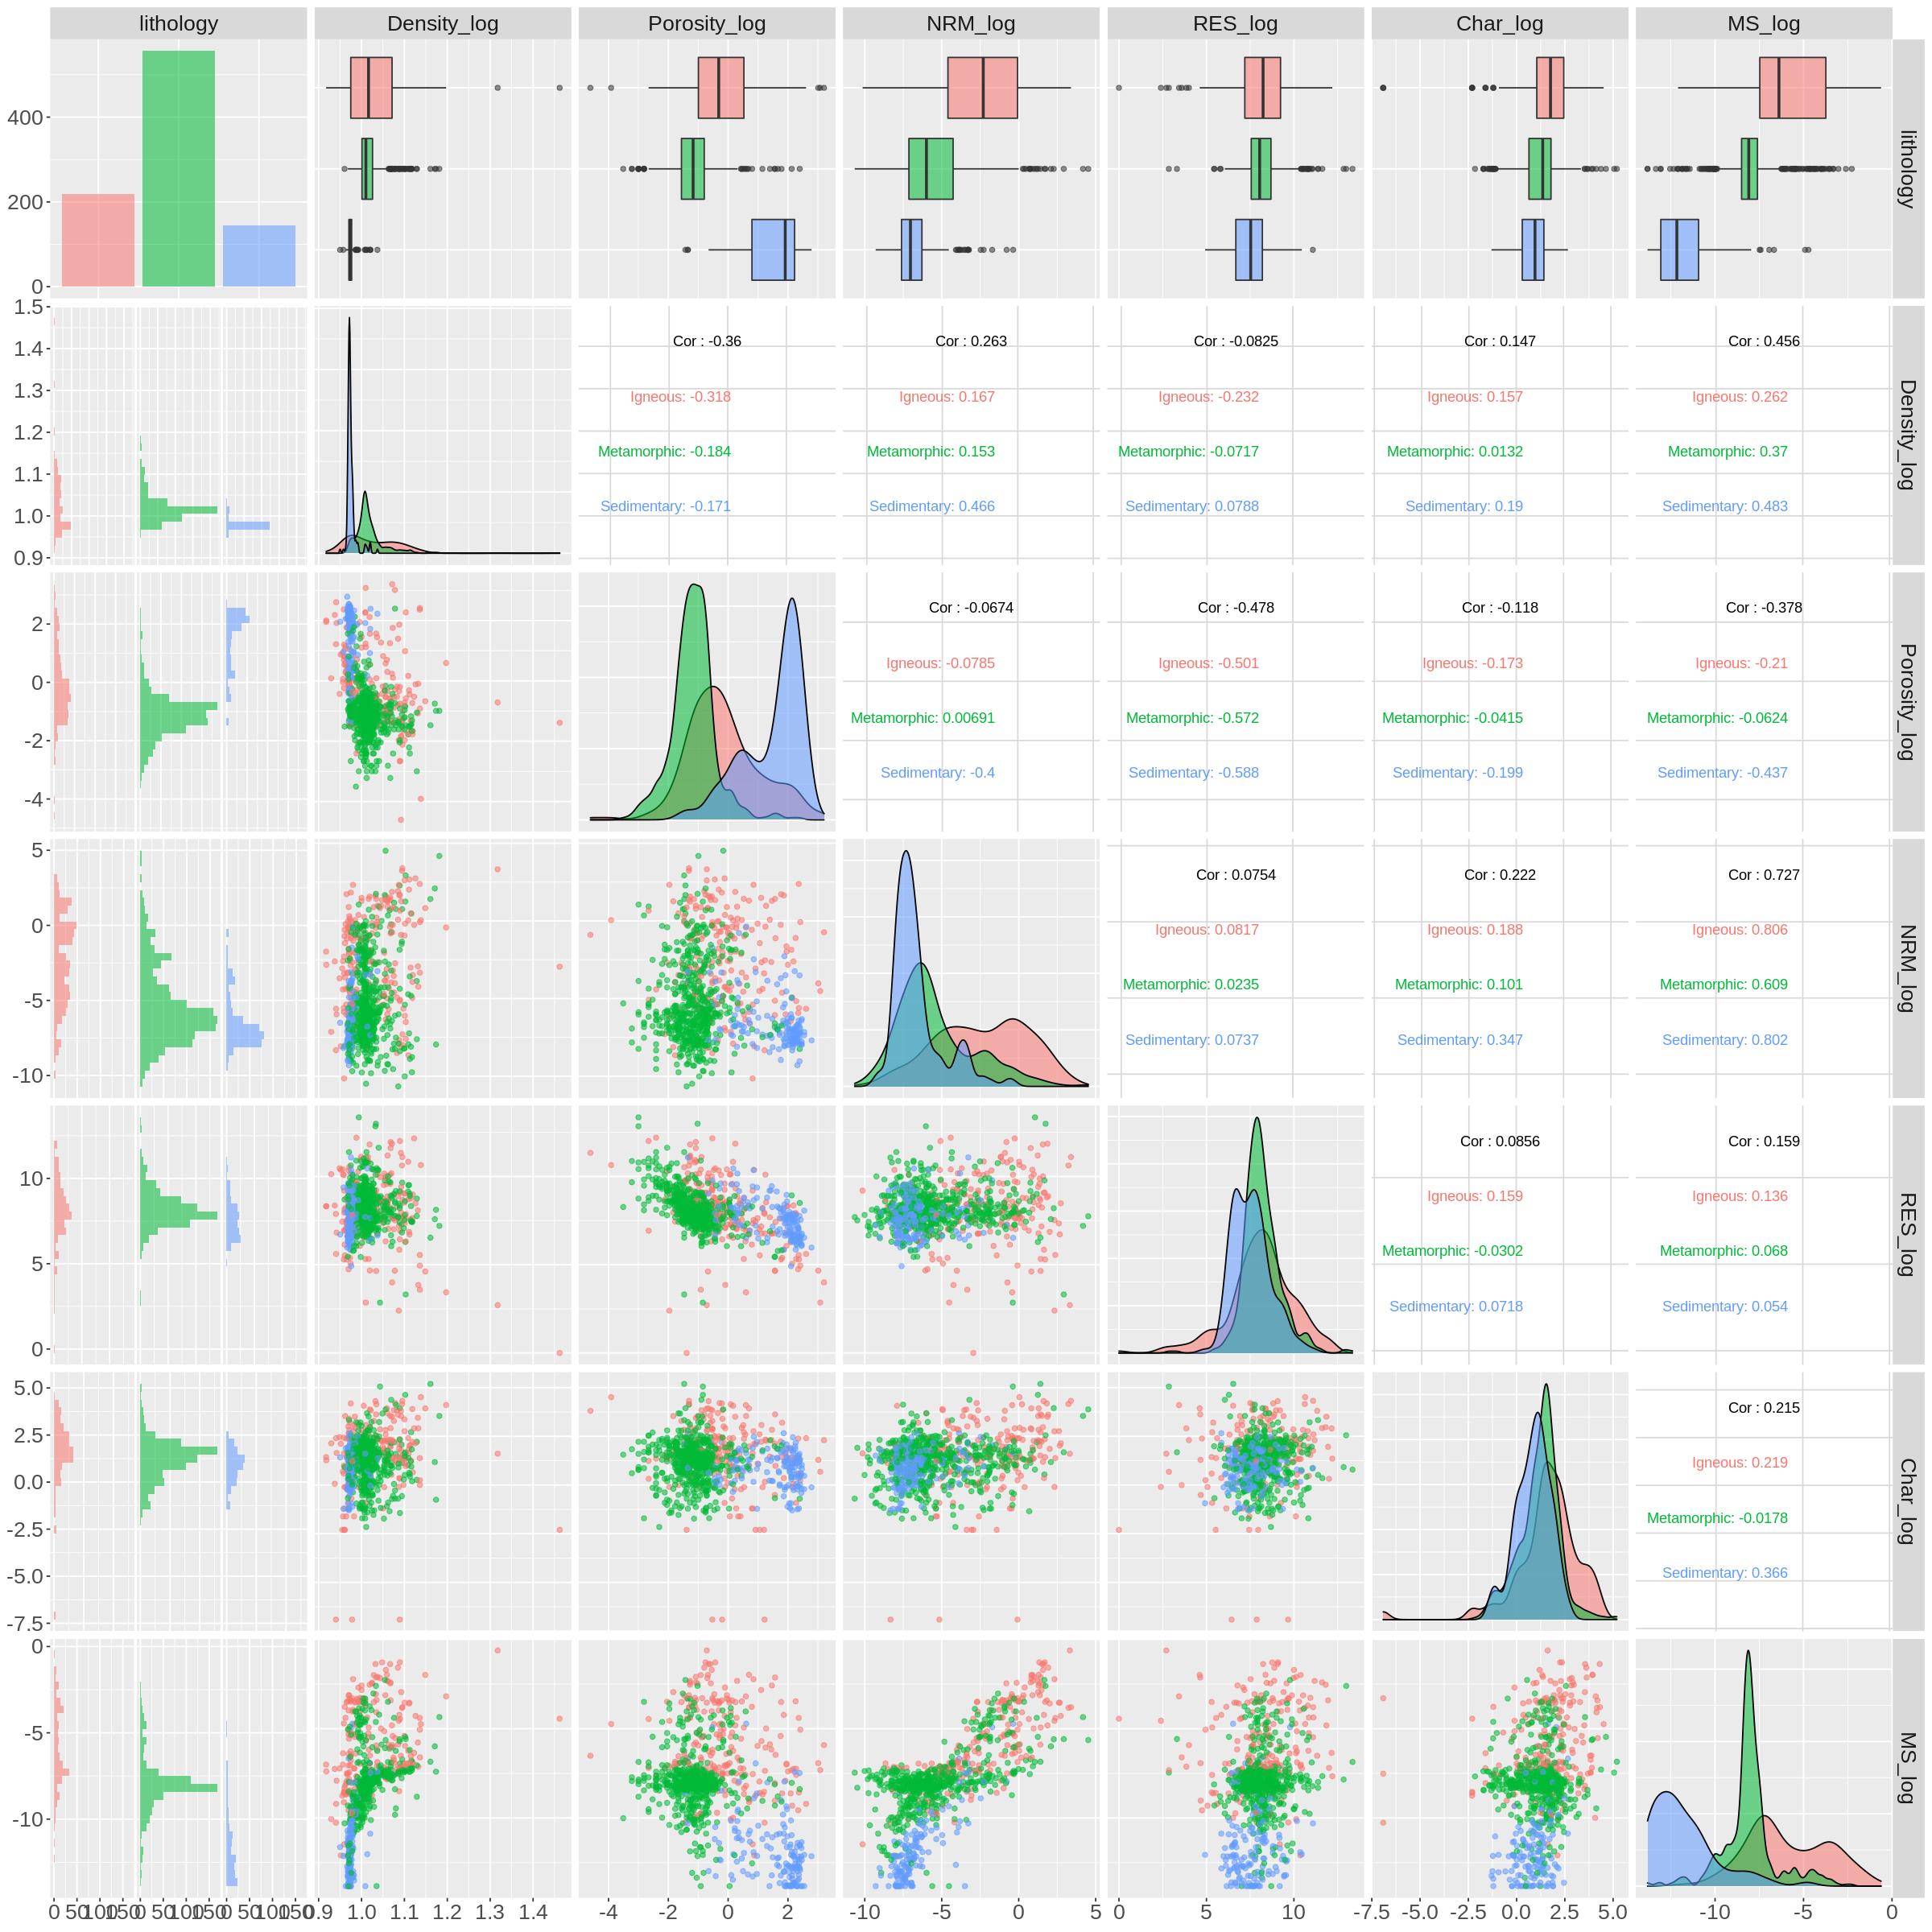

In [76]:
options(repr.plot.width = 20, repr.plot.height = 20)

train_pairs <- data_train_log %>%
    ggpairs(aes(colour = lithology, alpha=0.2))+
    theme(text = element_text(size = 20))
train_pairs

*Figure4: A scatterplot matrix shows the relationship between the six predictors*

The scatter plot shows the relationship between selected predictors, MS vs. Porosity under three Lithology types in log scale.

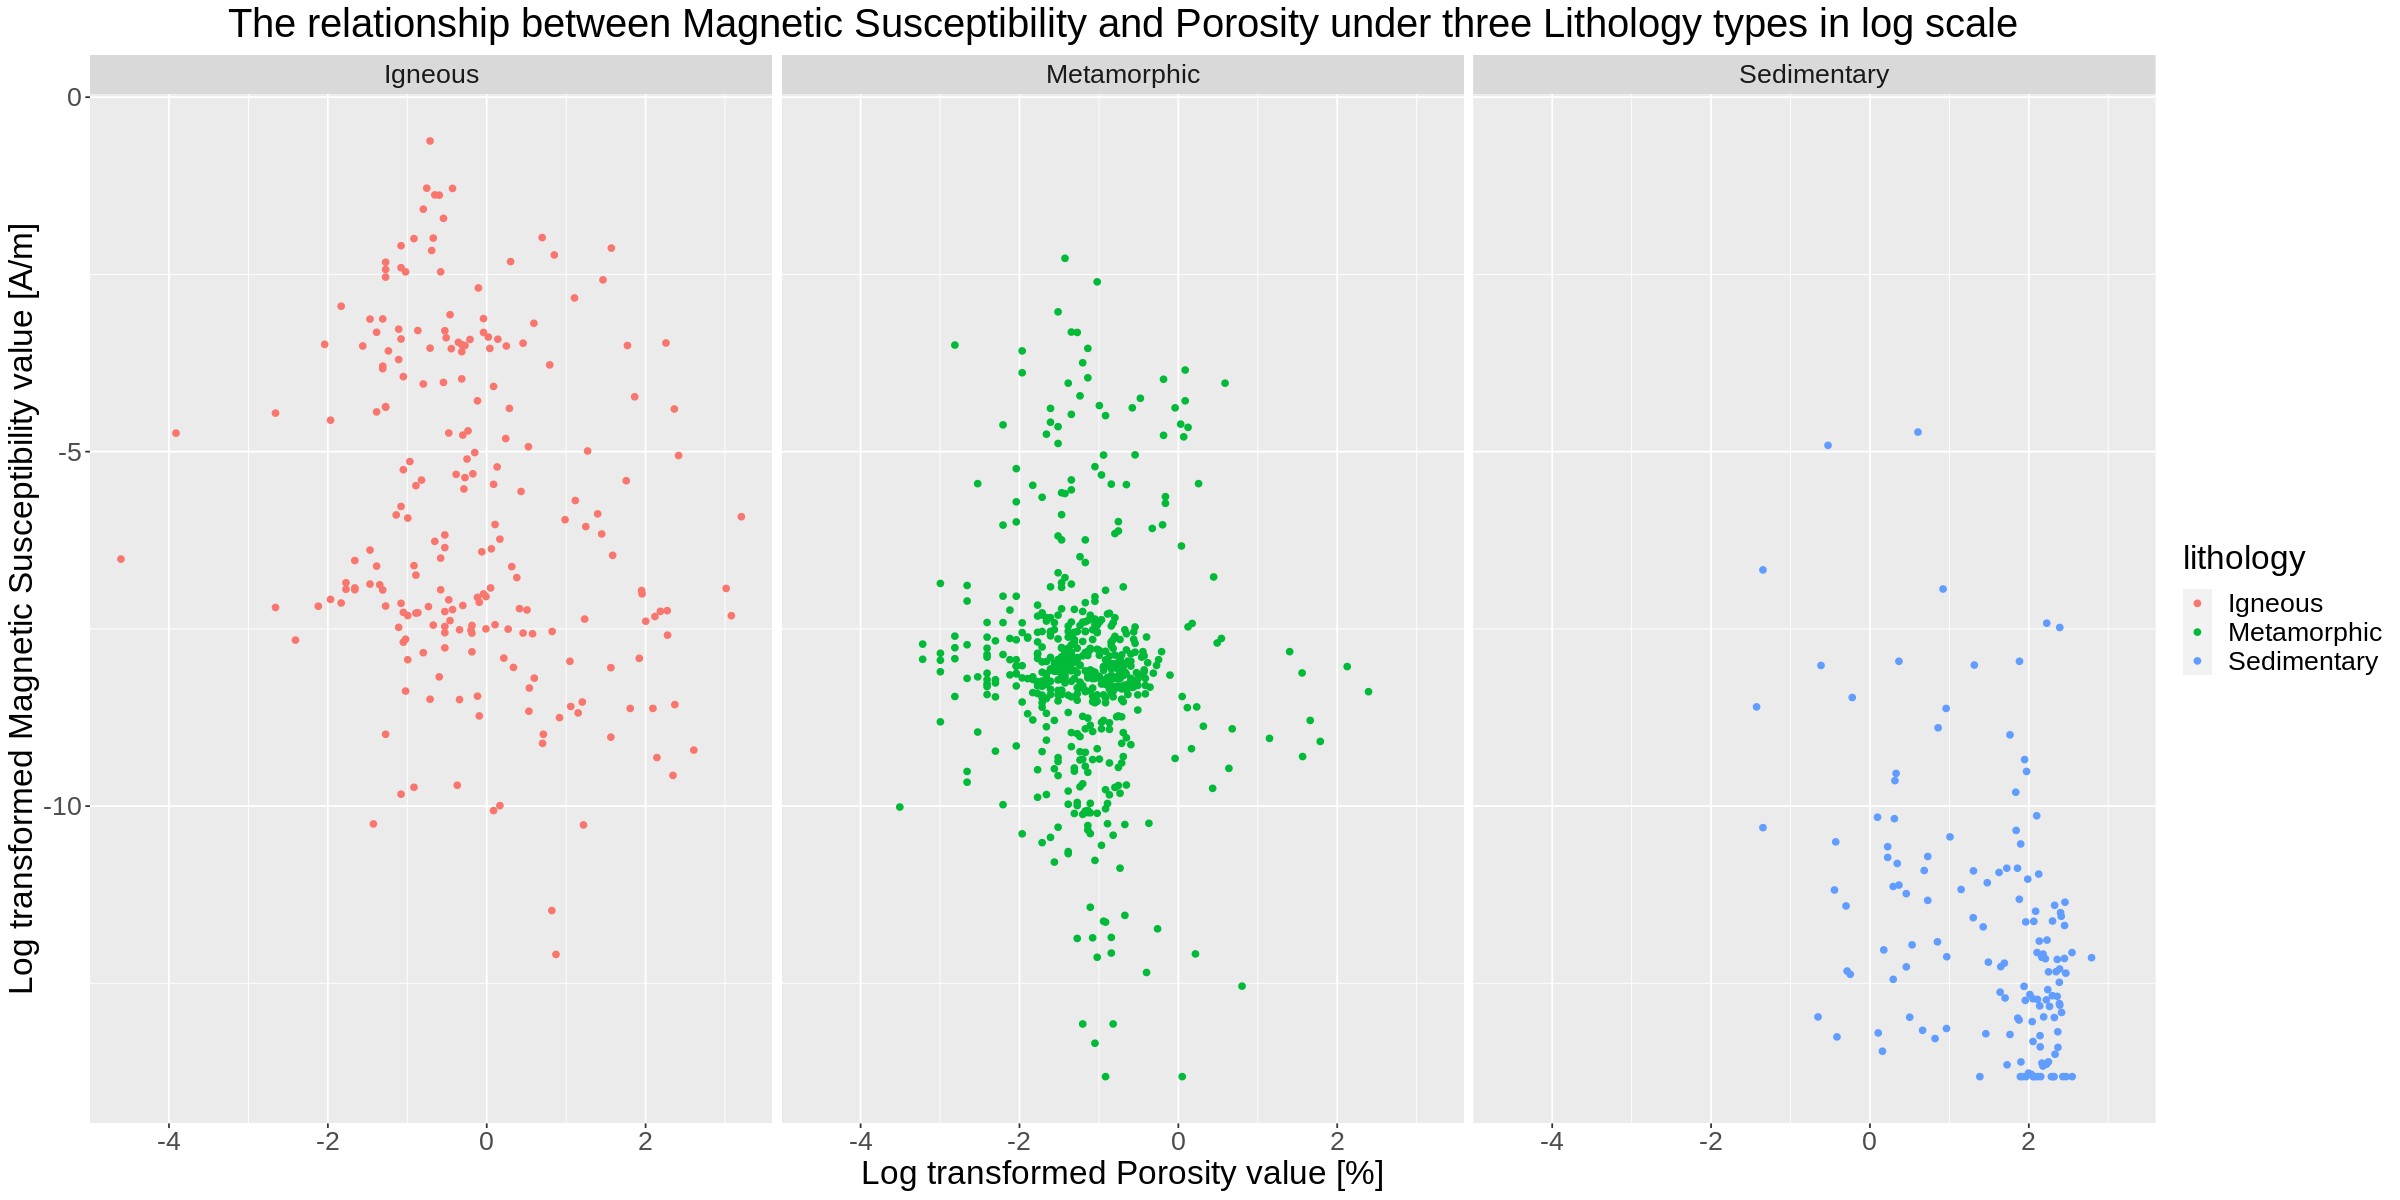

In [77]:
options(repr.plot.width = 20, repr.plot.height = 10)

training_plot <- data_train_log %>%
    ggplot(aes(x = Porosity_log, y = MS_log, color = lithology)) +
    geom_point() +
    facet_grid(. ~ lithology) +
    labs(title = "The relationship between Magnetic Susceptibility and Porosity under three Lithology types in log scale", 
         x = "Log transformed Porosity value [%]", y = "Log transformed Magnetic Susceptibility value [A/m]") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
training_plot

*Figure5: Scatterplot shows the relationship between Magnetic Susceptibility and Porosity under three Lithology types in log scale*

neighbors .metric  .estimator mean      n std_err    .config
1  17        accuracy multiclass 0.8357529 5 0.01056029 Model17
2  18        accuracy multiclass 0.8357470 5 0.01099696 Model18
3  19        accuracy multiclass 0.8346659 5 0.01226560 Model19
⋮  ⋮         ⋮        ⋮          ⋮         ⋮ ⋮          ⋮      
18 3         accuracy multiclass 0.8085369 5 0.01261623 Model03
19 1         accuracy multiclass 0.7845874 5 0.01343427 Model01
20 2         accuracy multiclass 0.7845874 5 0.01343427 Model02

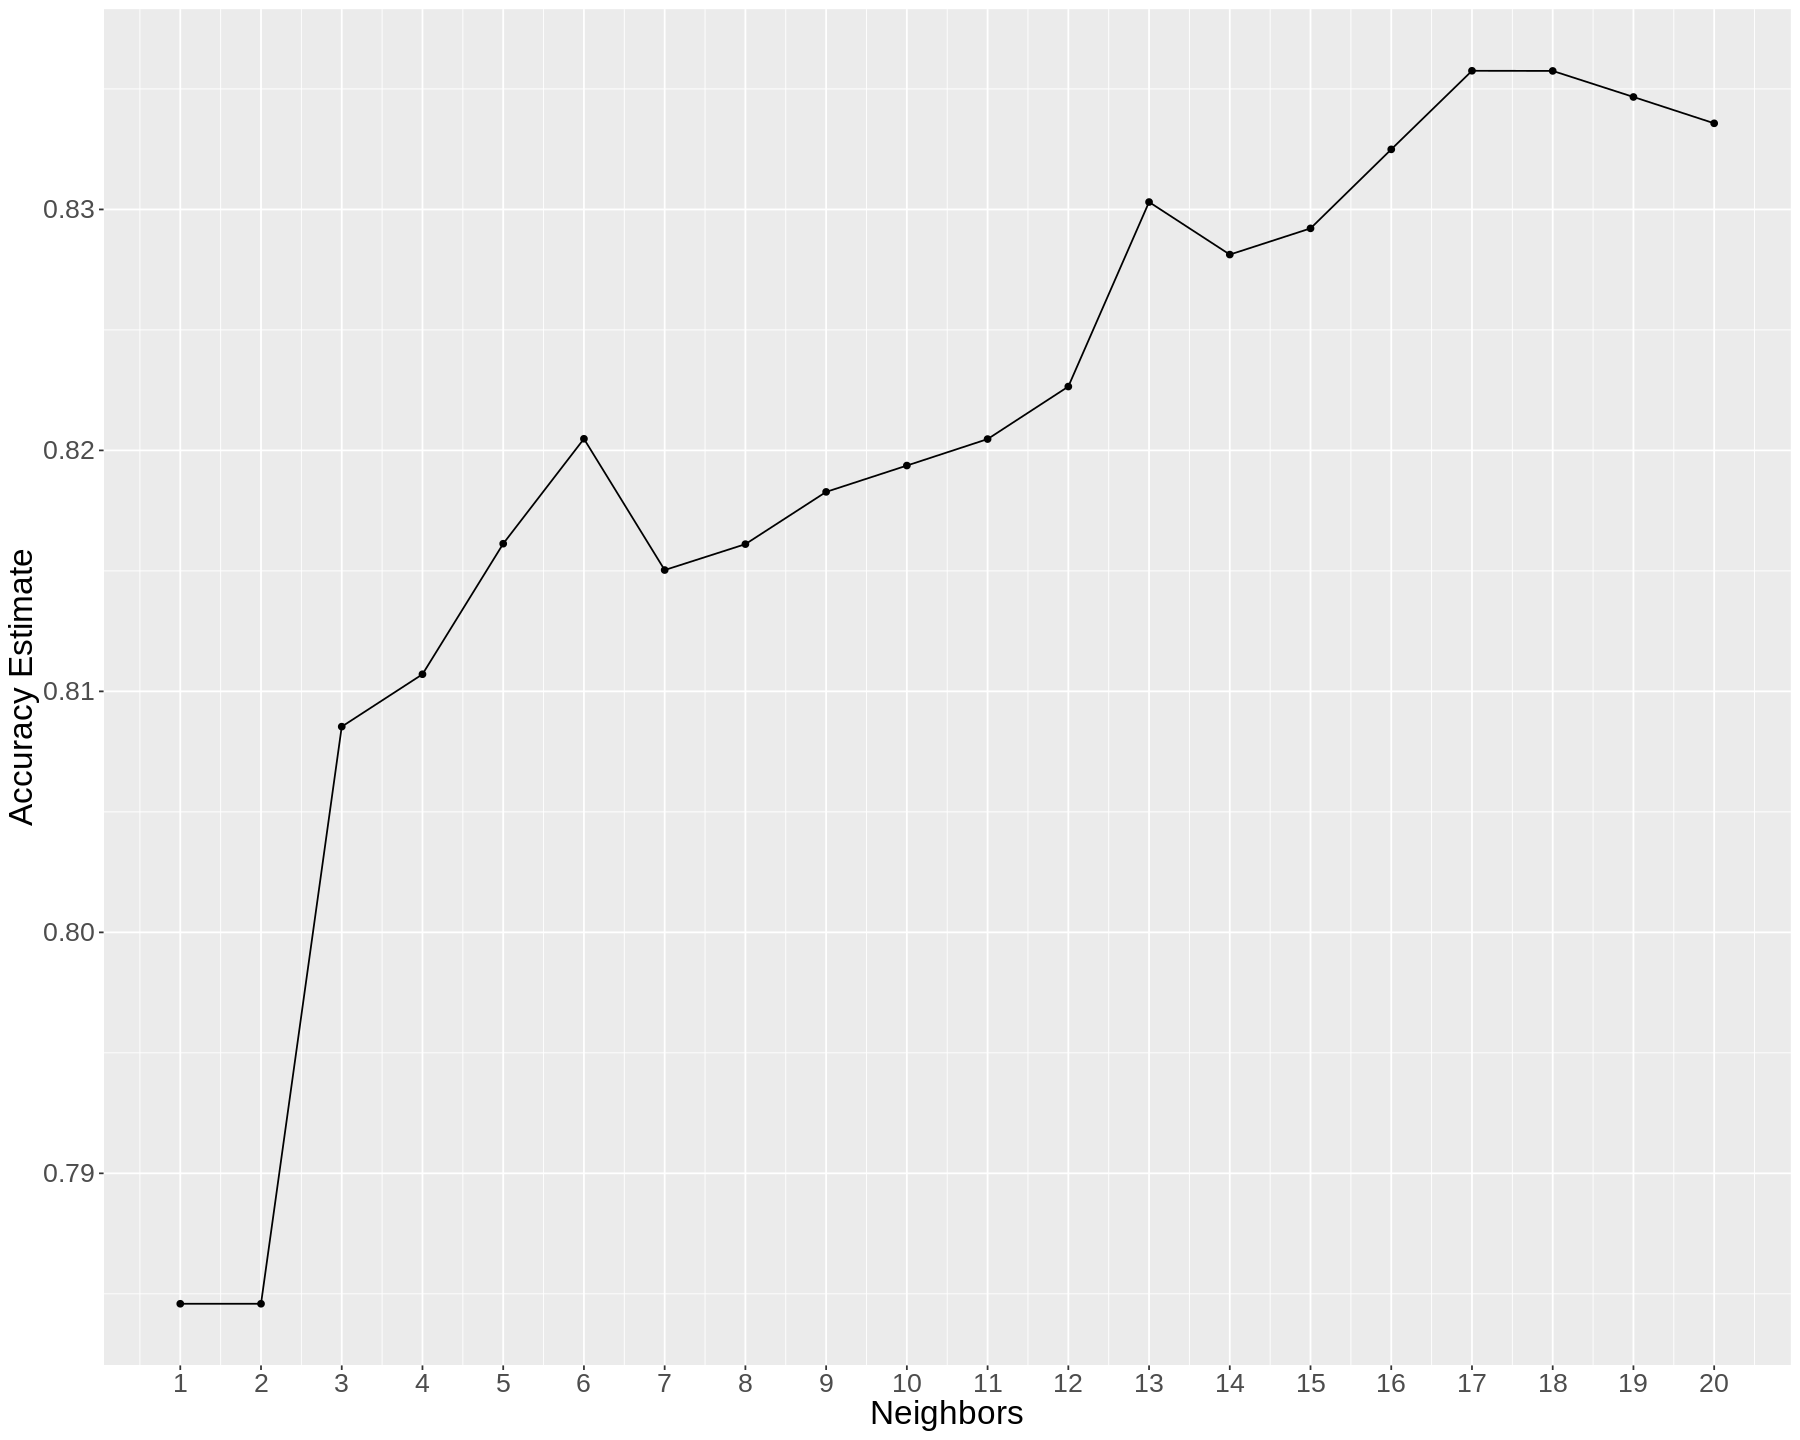

In [101]:
set.seed(100)
options(repr.plot.width = 15, repr.plot.height = 12)

train_recipe <- recipe(lithology ~ Porosity_log + MS_log, data = data_train_log) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

training_vfold <- vfold_cv(data_train_log, v = 5, strata = lithology)

k_vals <- tibble(neighbors = seq(1, 20))

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_result <- workflow() %>%
    add_recipe(train_recipe) %>%
    add_model(knn_tune) %>%        
    tune_grid(resamples = training_vfold, grid = k_vals) %>%
    collect_metrics()

accuracies <- knn_result %>% 
    filter(.metric == "accuracy") %>%
    arrange(desc(mean))
accuracies

top_k <- accuracies %>% 
    head(1) %>%
    select("neighbors") %>%
    pull()

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 20, by = 1)) + 
    theme(text = element_text(size = 20))
accuracy_versus_k


In [113]:
data_train_log <- data_train[is.na(data_train[2])]%>%
    mutate(
            Porosity_log = log(porosity), 
            MS_log = log(abs(MS))) %>%
    select("lithology","density", "Porosity_log", "NRM", "RES", "chargeability","MS_log")
data_train_log

ERROR: Error: Subscript `is.na(data_train[2])` is a matrix, it must have the same dimensions as the input.


In [90]:
knn_final <- nearest_neighbor(weight_func = "rectangular", neighbors = top_k) %>%
       set_engine("kknn") %>%
       set_mode("classification")

rock_model <- workflow() %>%
       add_recipe(train_recipe) %>%
       add_model(knn_final) %>%
       fit(data = data_train_log)

rock_model 

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~top_k,     kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.171926
Best kernel: rectangular
Best k: 17

In [91]:
data_test_log <- data_test %>%
    na.omit()%>%
    mutate(Density_log = log(density),
            Porosity_log = log(porosity), 
            NRM_log = log(NRM), 
            RES_log = log(RES), 
            Char_log = log(chargeability),
            MS_log = log(abs(MS)))%>%
    select("lithology","Density_log", "Porosity_log", "NRM_log", "RES_log", "Char_log","MS_log")
data_test_log 

lithology   Density_log Porosity_log NRM_log    RES_log   Char_log   
1   Igneous     0.9612641   -0.3285041   -7.3416199  8.565983 0.9162907  
2   Igneous     1.0310470   -1.0788097    1.0919233  9.752665 2.5336968  
3   Igneous     1.0777291   -1.0788097   -0.9571127 10.165852 1.8718022  
⋮   ⋮           ⋮           ⋮            ⋮          ⋮         ⋮          
294 Metamorphic 0.9943623    1.406097    -5.732182   5.899897  2.21920348
295 Metamorphic 0.9858168   -1.272966    -5.079985  11.608236 -0.08773891
296 Metamorphic 1.0264000   -1.832581    -7.821549  10.207289  2.08268627
    MS_log   
1   -9.631935
2   -1.725972
3   -3.405205
⋮   ⋮        
294 -8.645027
295 -7.915613
296 -8.691547

In [92]:
rock_prediction <- predict(rock_model, data_test_log) %>% bind_cols(data_test_log)
rock_prediction

prediction_accuracy <- rock_prediction %>% 
    metrics(truth = lithology, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

prediction_accuracy

prediction_confusion <- rock_prediction %>%
             conf_mat(truth = lithology, estimate = .pred_class)
prediction_confusion

.pred_class lithology   Density_log Porosity_log NRM_log    RES_log  
1   Metamorphic Igneous     0.9612641   -0.3285041   -7.3416199  8.565983
2   Igneous     Igneous     1.0310470   -1.0788097    1.0919233  9.752665
3   Igneous     Igneous     1.0777291   -1.0788097   -0.9571127 10.165852
⋮   ⋮           ⋮           ⋮           ⋮            ⋮          ⋮        
294 Igneous     Metamorphic 0.9943623    1.406097    -5.732182   5.899897
295 Metamorphic Metamorphic 0.9858168   -1.272966    -5.079985  11.608236
296 Metamorphic Metamorphic 1.0264000   -1.832581    -7.821549  10.207289
    Char_log    MS_log   
1   0.9162907   -9.631935
2   2.5336968   -1.725972
3   1.8718022   -3.405205
⋮   ⋮           ⋮        
294  2.21920348 -8.645027
295 -0.08773891 -7.915613
296  2.08268627 -8.691547

.metric  .estimator .estimate
1 accuracy multiclass 0.8445946

             Truth
Prediction    Igneous Metamorphic Sedimentary
  Igneous          38          12           1
  Metamorphic      24         175           5
  Sedimentary       2           2          37

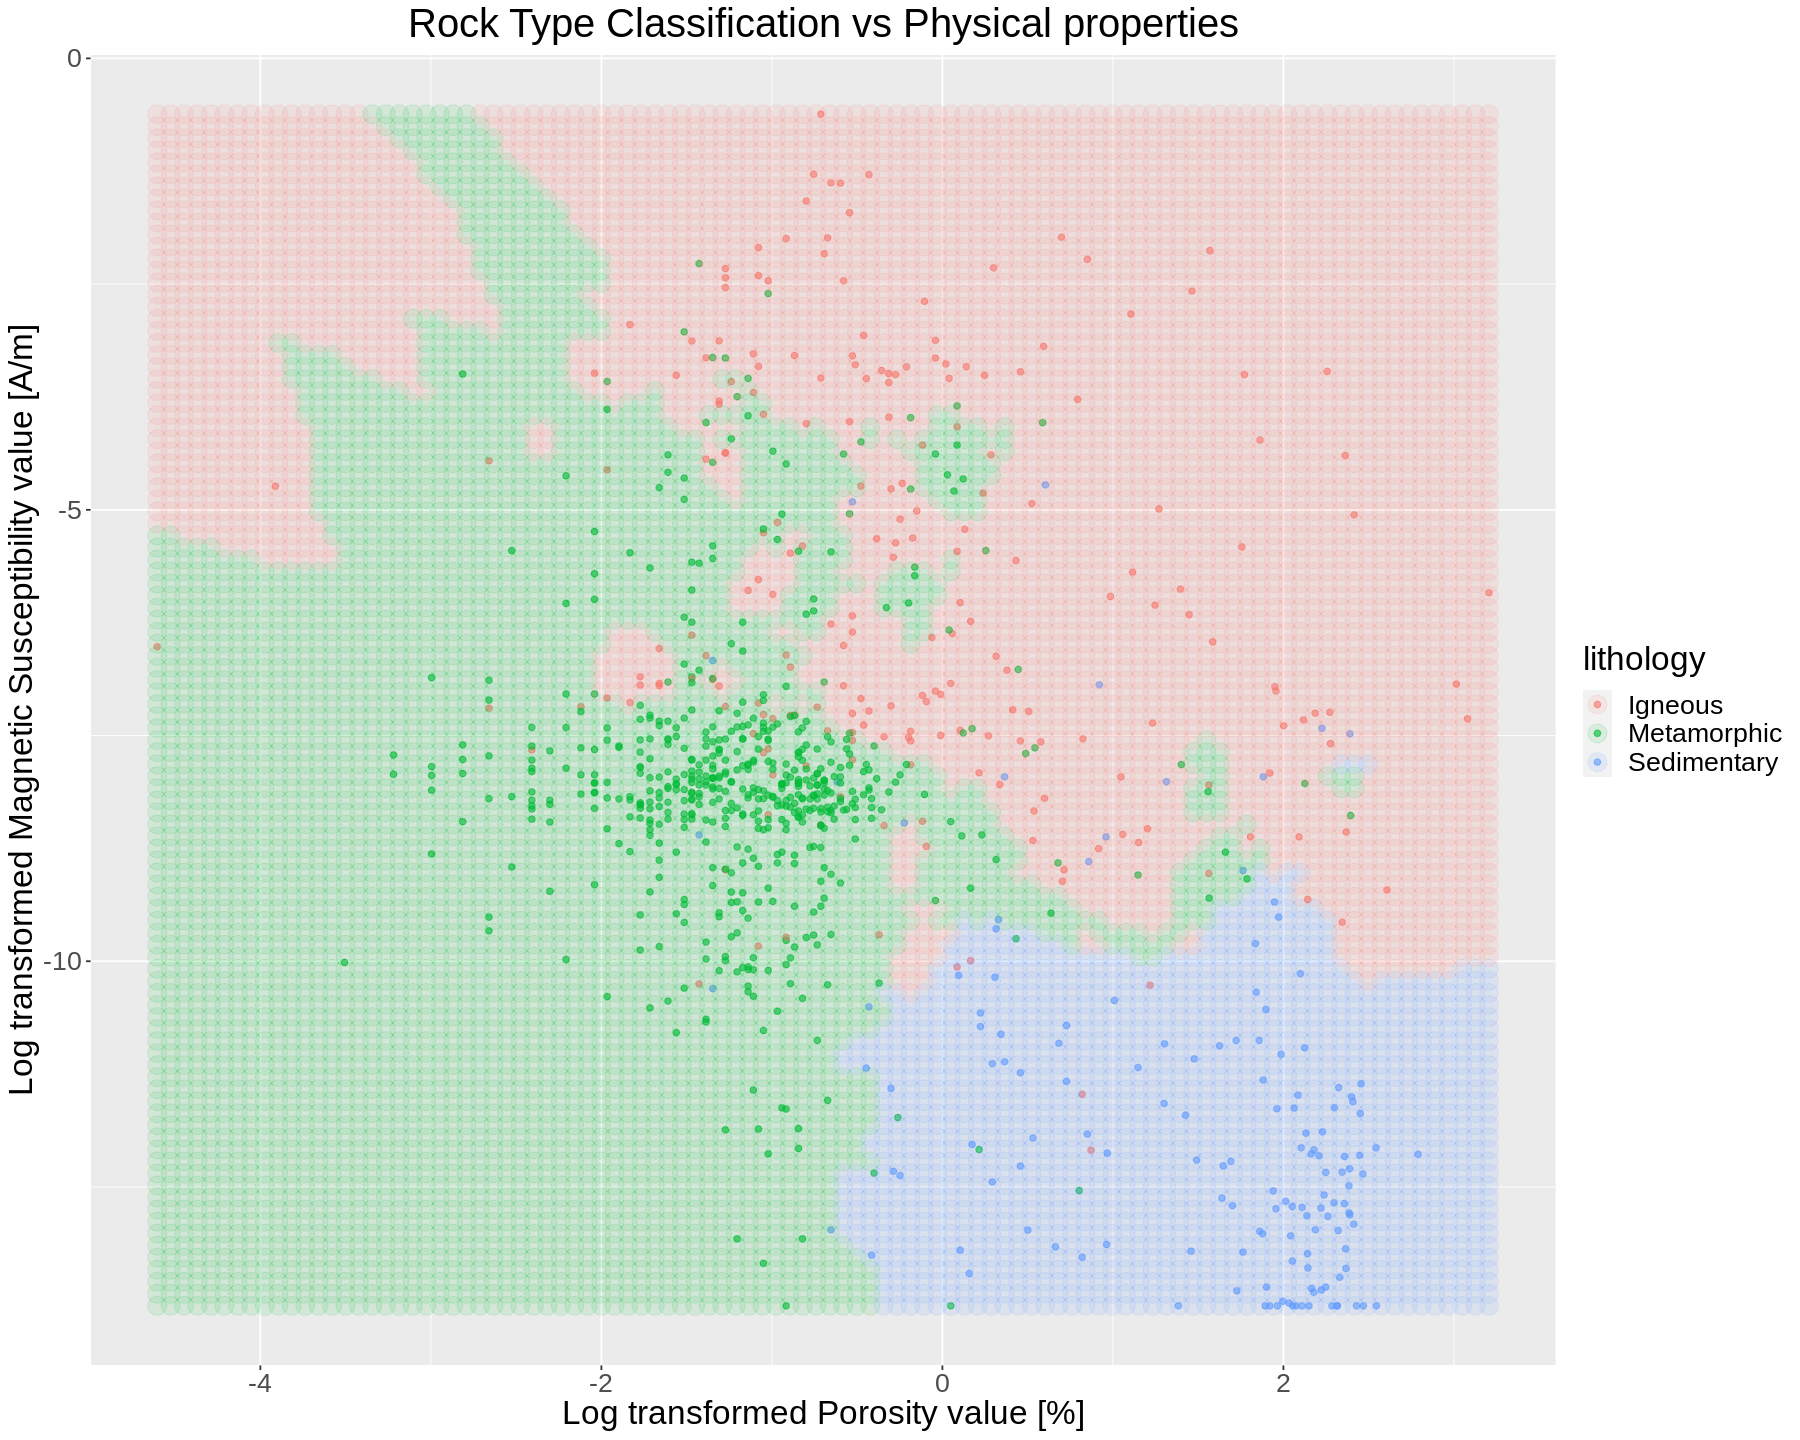

In [87]:
options(repr.plot.width = 15, repr.plot.height = 12)

# create the grid of area/smoothness vals, and arrange in a data frame
are_grid <- seq(min(data_train_log$Porosity_log), 
                max(data_train_log$Porosity_log), 
                length.out = 100)
smo_grid <- seq(min(data_train_log$MS_log), 
                max(data_train_log$MS_log),
                length.out = 100)
asgrid <- as_tibble(expand.grid(Porosity_log = are_grid, MS_log = smo_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(rock_model, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>% rename(lithology = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
    ggplot() +
    geom_point(data = data_train_log,
               mapping = aes(x = Porosity_log, y = MS_log, color = lithology), alpha = 0.6) +
    geom_point(data = prediction_table, 
               mapping = aes(x = Porosity_log, y = MS_log, color = lithology), alpha = 0.1, size = 5) +
    ggtitle("Rock Type Classification vs Physical properties") +
    labs(x = "Log transformed Porosity value [%]", y = "Log transformed Magnetic Susceptibility value [A/m]") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))

wkflw_plot